### Datasets and DataLoaders

In [1]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 50.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
def get_direct_subfolders(directory):
    subfolders = [f.path for f in os.scandir(directory) if f.is_dir()]
    return subfolders

def get_direct_subfiles(directory):
    subfiles = [f.path for f in os.scandir(directory) if f.is_file()]
    return subfiles

In [4]:
import os, torch, random, numpy as np, albumentations as A, nibabel as nib
from matplotlib import pyplot as plt; from glob import glob
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
import gc


class CustomSegmentationDataset(Dataset):

    def __init__(self, data_path, transformations = None):
        self.ims, self.gts, self.patient_numbers = self.get_slices(data_path)
        self.transformations = transformations
        self.n_cls = 2

        assert len(self.ims) == len(self.gts)

    def __len__(self): return len(self.ims)

    def __getitem__(self, idx):

        im, gt, patient_number = self.ims[idx], self.gts[idx], self.patient_numbers[idx]
        if self.transformations: im, gt = self.apply_transformations(im, gt)

        # For visualization purposes
        im = self.preprocess_im(im)
        # For the cases when label equals to 2; to avoid CE Loss error
        gt[gt > 1] = 1

        return im.float(), gt.unsqueeze(0).long(),patient_number

    def preprocess_im(self, im):

        max_val = torch.max(im)
        im[im < 0] = 0

        return im / max_val

    def get_slices(self, data_path):
      ims, gts, patient_numbers = [], [], []
      subfolders = get_direct_subfolders(data_path)
      for subfolder in subfolders:
          print("Petient folder: ", subfolder)
          subfiles = get_direct_subfiles(subfolder)
          # paths:
          seg_file = os.path.join( subfolder, os.path.basename(subfolder)+"-seg.nii.gz")
          t1c_file = os.path.join( subfolder, os.path.basename(subfolder)+"-t2f.nii.gz")
          patient_numbers.append(os.path.basename(subfolder))
          nifti_img_seg = nib.load(seg_file)
          nifti_img_t1c = nib.load(t1c_file)
          # Get the image data as a NumPy array
          img_data_seg = nifti_img_seg.get_fdata()
          img_data_t1c = nifti_img_t1c.get_fdata()
          # Find the index of the frame with the most pixels above zero
          nonzero_counts = [np.count_nonzero(slice_img) for slice_img in img_data_seg.transpose(2, 0, 1)]
          max_index = np.argmax(nonzero_counts)
          # Extract the frame with the most pixels above zero
          selected_frame_seg = img_data_seg[:, :, max_index]
          selected_frame_t1c = img_data_t1c[:, :, max_index]
          del nifti_img_seg
          del nifti_img_t1c

          del img_data_seg
          del img_data_t1c
          gts.append(selected_frame_seg)
          ims.append(selected_frame_t1c)
          gc.collect()

          if len(ims)==400:
            break
      return ims, gts, patient_numbers

    def read_nii(self, im, gt): return nib.load(im).get_fdata().transpose(2, 1, 0), nib.load(gt).get_fdata().transpose(2, 1, 0)

    def apply_transformations(self, im, gt): transformed = self.transformations(image = im, mask = gt); return transformed["image"], transformed["mask"]

def get_dls(path, transformations, bs, split = [0.9, 0.05, 0.05], ns = 4):

    assert sum(split) == 1., "Sum of the split must be exactly 1"

    ds = CustomSegmentationDataset(data_path = path, transformations = transformations)
    n_cls = ds.n_cls

    tr_len = int(len(ds) * split[0])
    val_len = int(len(ds) * split[1])
    test_len = int(len(ds) - (tr_len + val_len))

    # Data split
    # tr_ds, val_ds, test_ds = torch.utils.data.random_split(ds, [tr_len, val_len, test_len])
    tr_ds, val_ds, test_ds = torch.utils.data.random_split(ds, [tr_len, val_len, test_len])


    print(f"\nThere are {len(tr_ds)} number of images in the train set")
    print(f"There are {len(val_ds)} number of images in the validation set")
    print(f"There are {len(test_ds)} number of images in the test set\n")

    # Get dataloaders
    tr_dl  = DataLoader(dataset = tr_ds, batch_size = bs, shuffle = True, num_workers = ns)
    val_dl = DataLoader(dataset = val_ds, batch_size = bs, shuffle = False, num_workers = ns)
    test_dl = DataLoader(dataset = test_ds, batch_size = 1, shuffle = False, num_workers = ns)

    return tr_dl, val_dl, test_dl, n_cls

data_path = r'/content/drive/MyDrive/Brats21 Data/Dataset/training/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData'

mean, std, im_h, im_w = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 256, 256
trans = A.Compose( [A.Resize(im_h, im_w), ToTensorV2(transpose_mask = True) ])
tr_dl, val_dl, test_dl, n_cls = get_dls(path = data_path, transformations = trans, bs = 16)

Petient folder:  /content/drive/MyDrive/Brats21 Data/Dataset/training/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-01291-000
Petient folder:  /content/drive/MyDrive/Brats21 Data/Dataset/training/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-01292-000
Petient folder:  /content/drive/MyDrive/Brats21 Data/Dataset/training/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-01281-000
Petient folder:  /content/drive/MyDrive/Brats21 Data/Dataset/training/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-01282-000
Petient folder:  /content/drive/MyDrive/Brats21 Data/Dataset/training/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-01283-000
Petient folder:  /content/drive/MyDrive/Brats21 Data/Dataset/training/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-01284-000
Petient folder:  /content/drive/MyDrive/Brats21 Data/Dataset/training/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-01285-000
Petient folder:  /content/d

### Data Visualization

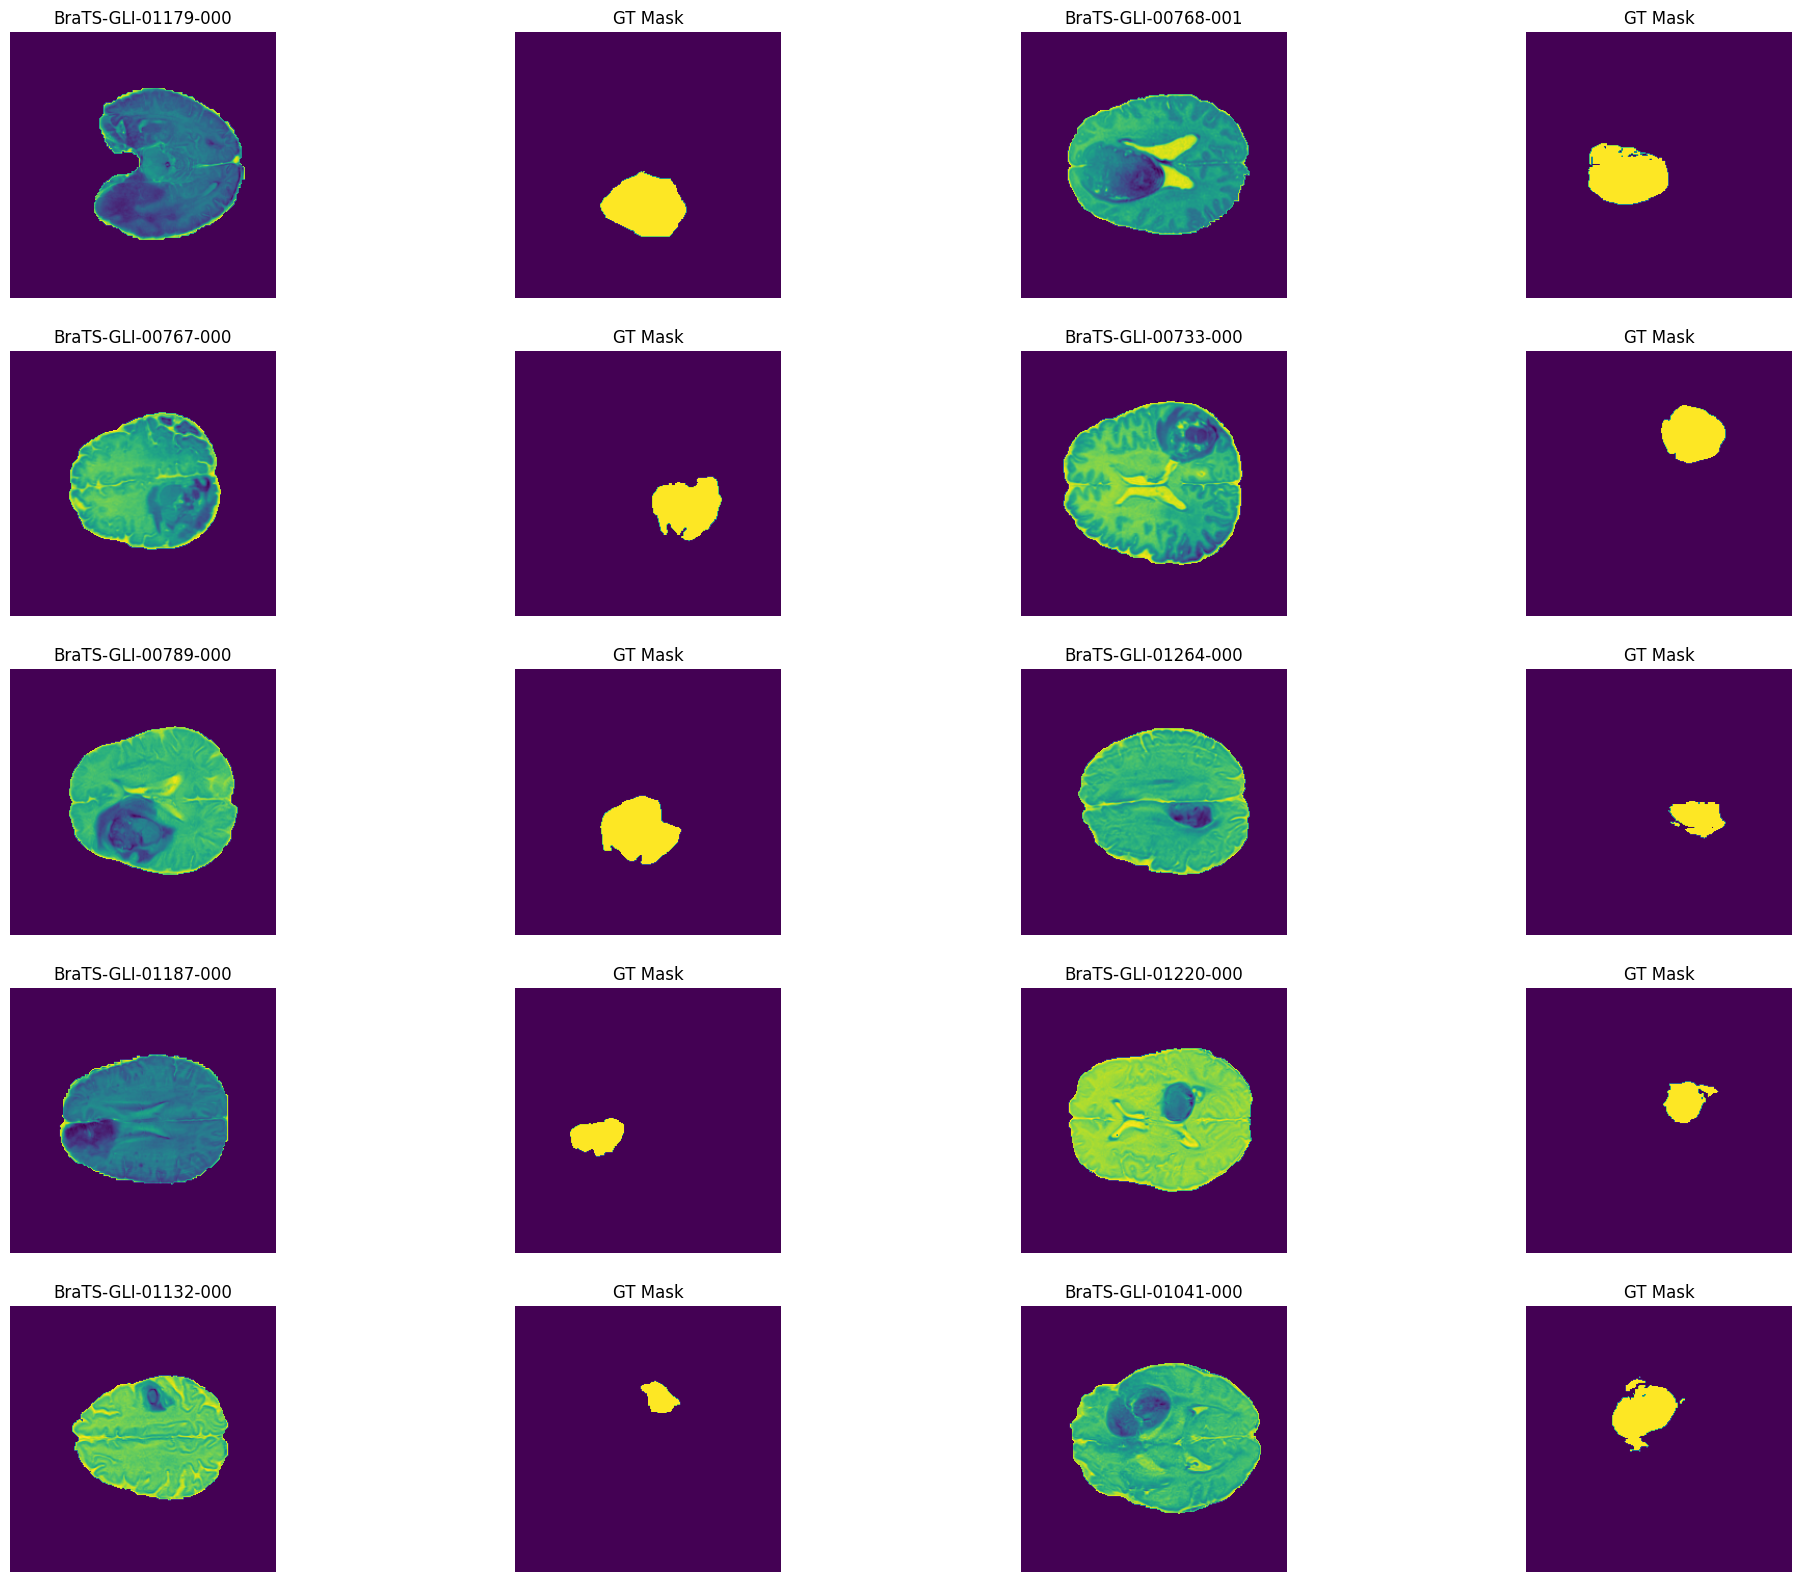

In [5]:
def plot(rows, cols, count, im, gt = None, title = "Original Image"):

    plt.subplot(rows, cols, count)
    plt.imshow(im.squeeze(0).float()) if gt else plt.imshow((im * 255).cpu().permute(1, 2, 0).numpy().astype("uint8") * 255)
    plt.axis("off"); plt.title(title)

    return count + 1

def visualize(ds, n_ims):

    plt.figure(figsize = (25, 20))
    rows = n_ims // 4; cols = n_ims // rows
    count = 1
    indices = [random.randint(0, len(ds) - 1) for _ in range(n_ims)]

    for idx, index in enumerate(indices):

        if count == n_ims + 1: break

        im, gt, patient_number = ds[index]

        # First Plot
        count = plot(rows, cols, count, im = im,title=patient_number)

        # Second Plot
        count = plot(rows, cols, count, im = gt.squeeze(0), gt = True, title = "GT Mask")

visualize(tr_dl.dataset, n_ims = 20)

### Train Setup and Evaluation Metrics

In [6]:
import segmentation_models_pytorch as Unet, time
from tqdm import tqdm
from torch.nn import functional as F

model = Unet.DeepLabV3Plus(classes = n_cls, in_channels = 1)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-4)

class Metrics():

    def __init__(self, pred, gt, loss_fn, eps = 1e-10, n_cls = 2):

        self.pred, self.gt = torch.argmax(pred, dim = 1) > 0, gt # (batch, width, height)
        self.loss_fn, self.eps, self.n_cls, self.pred_, self.device = loss_fn, eps, n_cls, pred, device

    def to_contiguous(self, inp): return inp.contiguous().view(-1)

    def PA(self):

        with torch.no_grad():
            match = torch.eq(self.pred, self.gt).int()

        return float(match.sum()) / float(match.numel())

    def mIoU(self):

        with torch.no_grad():

            pred, gt = self.to_contiguous(self.pred), self.to_contiguous(self.gt)

            iou_per_class = []

            for c in range(self.n_cls):

                match_pred = pred == c
                match_gt   = gt == c

                if match_gt.long().sum().item() == 0: iou_per_class.append(np.nan)

                else:

                    intersect = torch.logical_and(match_pred, match_gt).sum().float().item()
                    union = torch.logical_or(match_pred, match_gt).sum().float().item()

                    iou = (intersect + self.eps) / (union + self.eps)
                    iou_per_class.append(iou)

            return np.nanmean(iou_per_class)
    def mse_loss(self):
      output = self.pred.float()  # Convert output to float
      target = self.gt.float()  # Convert target to float
      return F.mse_loss(output, target).float()
    def loss(self): return self.loss_fn(self.pred_, self.gt.squeeze(1))

def tic_toc(start_time = None): return time.time() if start_time == None else time.time() - start_time

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 387MB/s]


### AI Model Train and Evaluation

In [7]:
save_prefix = "brats"
def train(model, tr_dl, val_dl, loss_fn, opt, device, epochs, save_prefix, threshold = 0.005, save_path = "saved_models"):

    tr_loss, tr_pa, tr_iou, tr_mse = [], [], [], []
    val_loss, val_pa, val_iou, val_mse = [], [], [], []
    tr_len, val_len = len(tr_dl), len(val_dl)
    best_loss, decrease, not_improve, early_stop_threshold = np.inf, 1, 0, 5
    os.makedirs(save_path, exist_ok = True)

    model.to(device)
    train_start = tic_toc()
    print("Start training process...")

    for epoch in range(1, epochs + 1):
        tic = tic_toc()
        tr_loss_, tr_iou_, tr_pa_, tr_mse_ = 0, 0, 0, 0

        model.train()
        print(f"Epoch {epoch} train process is started...")
        for idx, batch in enumerate(tqdm(tr_dl)):
            ims, gts,_ = batch
            ims, gts = ims.to(device), gts.to(device).long()

            preds = model(ims)

            met = Metrics(preds, gts, loss_fn, n_cls = n_cls)
            loss_ = met.loss().requires_grad_()

            tr_iou_ += met.mIoU()
            tr_pa_ += met.PA()
            tr_loss_ += loss_.item()
            tr_mse_ += met.mse_loss().item()

            loss_.backward()
            opt.step()
            opt.zero_grad()

        print(f"Epoch {epoch} validation process is started...")
        model.eval()
        val_loss_, val_iou_, val_pa_, val_mse_ = 0, 0, 0, 0

        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_dl)):

                ims, gts,_ = batch
                ims, gts = ims.to(device), gts.to(device)

                preds = model(ims)

                met = Metrics(preds, gts, loss_fn, n_cls = n_cls)

                val_loss_ += met.loss().item()
                val_iou_ += met.mIoU()
                val_pa_ += met.PA()
                val_mse_ += met.mse_loss().item()

        print(f"Epoch {epoch} train process is completed.")

        tr_loss_ /= tr_len
        tr_iou_ /= tr_len
        tr_pa_ /= tr_len
        tr_mse_ /= tr_len

        val_loss_ /= val_len
        val_iou_ /=  val_len
        val_pa_ /=   val_len
        val_mse_ /= val_len
        print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print(f"\nEpoch {epoch} train process results: \n")
        print(f"Train Time         -> {tic_toc(tic):.3f} secs")
        print(f"Train Loss         -> {tr_loss_:.3f}")
        print(f"Train PA           -> {tr_pa_:.3f}")
        print(f"Train IoU          -> {tr_iou_:.3f}")
        print(f"Train MSE          -> {tr_mse_:.3f}")
        print(f"Validation Loss    -> {val_loss_:.3f}")
        print(f"Validation PA      -> {val_pa_:.3f}")
        print(f"Validation IoU     -> {val_iou_:.3f}")
        print(f"Validation MSE     -> {val_mse_:.3f}\n")

        tr_loss.append(tr_loss_)
        tr_iou.append(tr_iou_)
        tr_pa.append(tr_pa_)
        tr_mse.append(tr_mse_)
        val_loss.append(val_loss_)
        val_iou.append(val_iou_)
        val_pa.append(val_pa_)
        val_mse.append(val_mse_)
        if best_loss > (val_loss_ + threshold):
            print(f"Loss decreased from {best_loss:.3f} to {val_loss_:.3f}!")
            best_loss = val_loss_
            decrease += 1
            if decrease % 2 == 0:
                print("Saving the model with the best loss value...")
                torch.save(model, f"{save_path}/{save_prefix}_best_model.pt")

        else:

            not_improve += 1
            best_loss = val_loss_
            print(f"Loss did not decrease for {not_improve} epoch(s)!")
            if not_improve == early_stop_threshold:
                print(f"Stopping training process becuase loss value did not decrease for {early_stop_threshold} epochs!")
                break
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

    print(f"Train process is completed in {(tic_toc(train_start)) / 60:.3f} minutes.")

    return {"tr_loss": tr_loss, "tr_iou": tr_iou, "tr_pa": tr_pa, "tr_mse": tr_mse,
            "val_loss": val_loss, "val_iou": val_iou, "val_pa" : val_pa, "val_mse" : val_mse}

device = "cuda" if torch.cuda.is_available() else "cpu"

history = train(model = model, tr_dl = tr_dl, val_dl = val_dl,
                 loss_fn = loss_fn, opt = optimizer, device = device,
                 epochs = 50, save_prefix = save_prefix)

Start training process...
Epoch 1 train process is started...


  0%|          | 0/23 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
<ipython-input-6-389ee3434690>:52: UserWarning: Using a target size (torch.Size([16, 1, 256, 256])) that is different to the input size (torch.Size([16, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(output, target).float()
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v

Epoch 1 validation process is started...


 50%|█████     | 1/2 [00:00<00:00,  1.82it/s]<ipython-input-6-389ee3434690>:52: UserWarning: Using a target size (torch.Size([4, 1, 256, 256])) that is different to the input size (torch.Size([4, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(output, target).float()
100%|██████████| 2/2 [00:00<00:00,  2.55it/s]


Epoch 1 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 1 train process results: 

Train Time         -> 5.973 secs
Train Loss         -> 0.365
Train PA           -> 0.857
Train IoU          -> 0.678
Train MSE          -> 0.143
Validation Loss    -> 0.375
Validation PA      -> 0.948
Validation IoU     -> 0.696
Validation MSE     -> 0.052

Loss decreased from inf to 0.375!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process is started...


100%|██████████| 23/23 [00:02<00:00,  9.65it/s]


Epoch 2 validation process is started...


100%|██████████| 2/2 [00:00<00:00,  2.94it/s]


Epoch 2 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process results: 

Train Time         -> 3.075 secs
Train Loss         -> 0.093
Train PA           -> 0.938
Train IoU          -> 0.845
Train MSE          -> 0.062
Validation Loss    -> 0.091
Validation PA      -> 0.944
Validation IoU     -> 0.831
Validation MSE     -> 0.056

Loss decreased from 0.375 to 0.091!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process is started...


100%|██████████| 23/23 [00:02<00:00,  9.80it/s]


Epoch 3 validation process is started...


100%|██████████| 2/2 [00:00<00:00,  2.98it/s]


Epoch 3 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process results: 

Train Time         -> 3.029 secs
Train Loss         -> 0.057
Train PA           -> 0.937
Train IoU          -> 0.882
Train MSE          -> 0.063
Validation Loss    -> 0.059
Validation PA      -> 0.947
Validation IoU     -> 0.839
Validation MSE     -> 0.053

Loss decreased from 0.091 to 0.059!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process is started...


100%|██████████| 23/23 [00:02<00:00,  9.85it/s]


Epoch 4 validation process is started...


100%|██████████| 2/2 [00:00<00:00,  3.00it/s]


Epoch 4 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process results: 

Train Time         -> 3.011 secs
Train Loss         -> 0.044
Train PA           -> 0.936
Train IoU          -> 0.897
Train MSE          -> 0.064
Validation Loss    -> 0.051
Validation PA      -> 0.947
Validation IoU     -> 0.848
Validation MSE     -> 0.053

Loss decreased from 0.059 to 0.051!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process is started...


100%|██████████| 23/23 [00:02<00:00,  9.84it/s]


Epoch 5 validation process is started...


100%|██████████| 2/2 [00:00<00:00,  2.93it/s]


Epoch 5 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process results: 

Train Time         -> 3.029 secs
Train Loss         -> 0.037
Train PA           -> 0.936
Train IoU          -> 0.908
Train MSE          -> 0.064
Validation Loss    -> 0.037
Validation PA      -> 0.944
Validation IoU     -> 0.897
Validation MSE     -> 0.056

Loss decreased from 0.051 to 0.037!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 train process is started...


100%|██████████| 23/23 [00:02<00:00,  9.72it/s]


Epoch 6 validation process is started...


100%|██████████| 2/2 [00:00<00:00,  2.94it/s]


Epoch 6 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 train process results: 

Train Time         -> 3.057 secs
Train Loss         -> 0.032
Train PA           -> 0.936
Train IoU          -> 0.916
Train MSE          -> 0.064
Validation Loss    -> 0.039
Validation PA      -> 0.946
Validation IoU     -> 0.877
Validation MSE     -> 0.054

Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 train process is started...


100%|██████████| 23/23 [00:02<00:00,  9.80it/s]


Epoch 7 validation process is started...


100%|██████████| 2/2 [00:00<00:00,  2.95it/s]


Epoch 7 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 train process results: 

Train Time         -> 3.038 secs
Train Loss         -> 0.030
Train PA           -> 0.937
Train IoU          -> 0.912
Train MSE          -> 0.063
Validation Loss    -> 0.039
Validation PA      -> 0.945
Validation IoU     -> 0.877
Validation MSE     -> 0.055

Loss did not decrease for 2 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 8 train process is started...


100%|██████████| 23/23 [00:02<00:00,  9.79it/s]


Epoch 8 validation process is started...


100%|██████████| 2/2 [00:00<00:00,  2.98it/s]


Epoch 8 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 8 train process results: 

Train Time         -> 3.032 secs
Train Loss         -> 0.027
Train PA           -> 0.935
Train IoU          -> 0.921
Train MSE          -> 0.065
Validation Loss    -> 0.035
Validation PA      -> 0.946
Validation IoU     -> 0.876
Validation MSE     -> 0.054

Loss did not decrease for 3 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 9 train process is started...


100%|██████████| 23/23 [00:02<00:00,  9.73it/s]


Epoch 9 validation process is started...


100%|██████████| 2/2 [00:00<00:00,  2.92it/s]


Epoch 9 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 9 train process results: 

Train Time         -> 3.061 secs
Train Loss         -> 0.024
Train PA           -> 0.936
Train IoU          -> 0.924
Train MSE          -> 0.064
Validation Loss    -> 0.031
Validation PA      -> 0.944
Validation IoU     -> 0.893
Validation MSE     -> 0.056

Loss did not decrease for 4 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 10 train process is started...


100%|██████████| 23/23 [00:02<00:00,  9.70it/s]


Epoch 10 validation process is started...


100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

Epoch 10 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 10 train process results: 

Train Time         -> 3.070 secs
Train Loss         -> 0.022
Train PA           -> 0.936
Train IoU          -> 0.928
Train MSE          -> 0.064
Validation Loss    -> 0.030
Validation PA      -> 0.946
Validation IoU     -> 0.890
Validation MSE     -> 0.054

Loss did not decrease for 5 epoch(s)!
Stopping training process becuase loss value did not decrease for 5 epochs!
Train process is completed in 0.566 minutes.


### Learning Curves

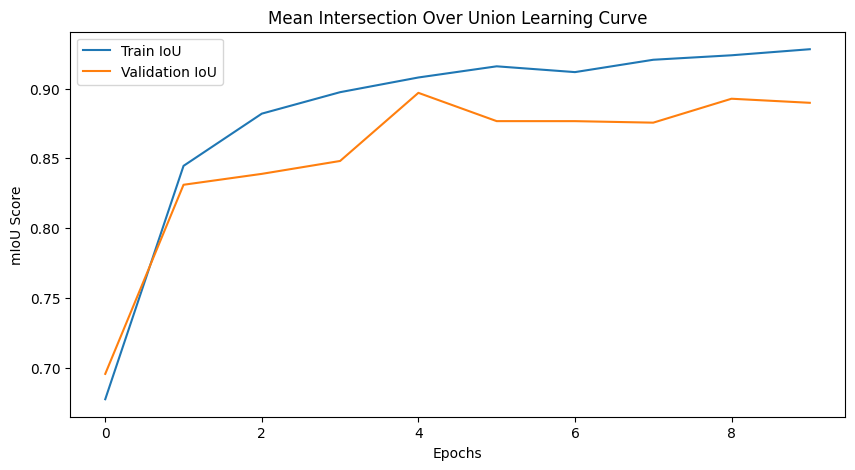

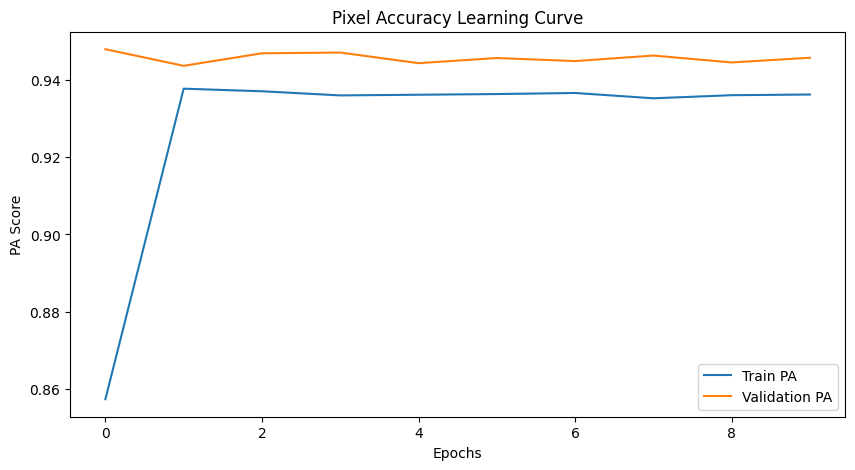

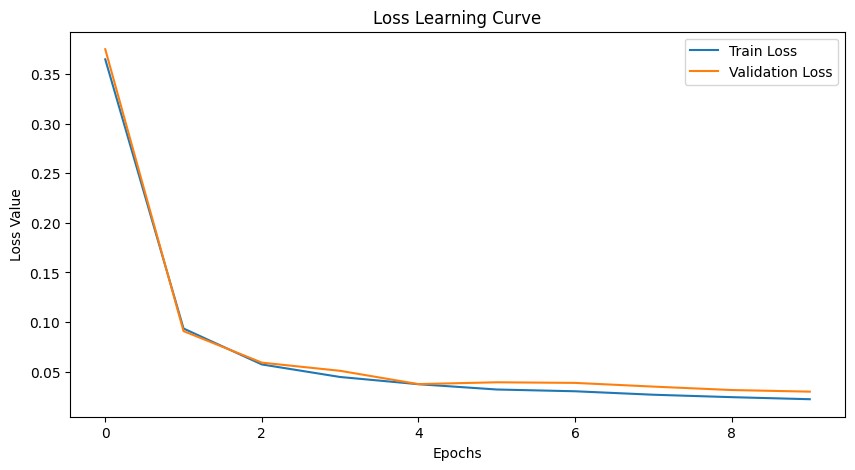

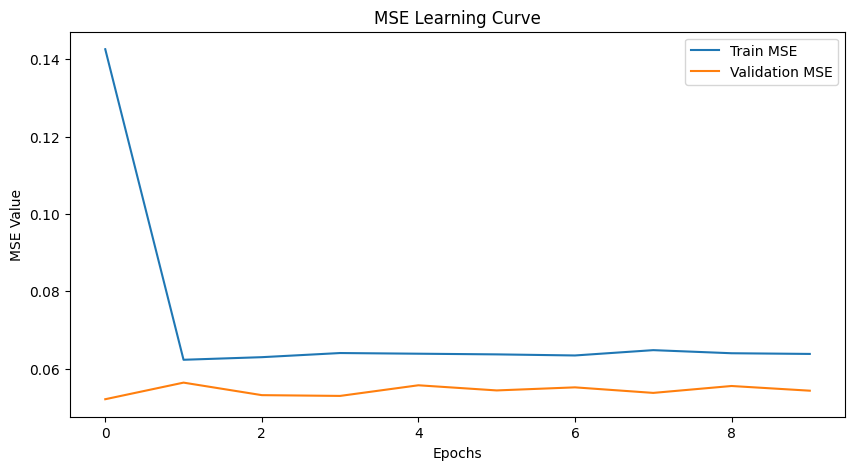

In [8]:
class Plot():

    def __init__(self, res):

        self.res = res

        self.visualize(metric1 = "tr_iou", metric2 = "val_iou", label1 = "Train IoU",
                  label2 = "Validation IoU", title = "Mean Intersection Over Union Learning Curve", ylabel = "mIoU Score")

        self.visualize(metric1 = "tr_pa", metric2 = "val_pa", label1 = "Train PA",
                  label2 = "Validation PA", title = "Pixel Accuracy Learning Curve", ylabel = "PA Score")

        self.visualize(metric1 = "tr_loss", metric2 = "val_loss", label1 = "Train Loss",
                  label2 = "Validation Loss", title = "Loss Learning Curve", ylabel = "Loss Value")
        self.visualize(metric1 = "tr_mse", metric2 = "val_mse", label1 = "Train MSE",
                  label2 = "Validation MSE", title = "MSE Learning Curve", ylabel = "MSE Value")
    def plot(self, metric, label): plt.plot(self.res[metric], label = label)

    def decorate(self, ylabel, title): plt.title(title); plt.xlabel("Epochs"); plt.ylabel(ylabel); plt.legend(); plt.show()

    def visualize(self, metric1, metric2, label1, label2, title, ylabel):

        plt.figure(figsize=(10, 5))
        self.plot(metric1, label1); self.plot(metric2, label2)
        self.decorate(ylabel, title)

Plot(history)

### Inference and Model Performance Analysis

patient number  ('BraTS-GLI-00736-000',)
IOU :  0.798797607421875
MSE :  0.201202392578125

patient number  ('BraTS-GLI-01230-000',)
IOU :  0.8189544677734375
MSE :  0.1810455322265625

patient number  ('BraTS-GLI-01022-000',)
IOU :  0.7230377197265625
MSE :  0.2769622802734375

patient number  ('BraTS-GLI-00773-000',)
IOU :  0.720703125
MSE :  0.279296875

patient number  ('BraTS-GLI-00714-001',)
IOU :  0.648773193359375
MSE :  0.351226806640625

patient number  ('BraTS-GLI-01174-000',)
IOU :  0.788177490234375
MSE :  0.211822509765625

patient number  ('BraTS-GLI-01172-000',)
IOU :  0.7783355712890625
MSE :  0.2216644287109375

patient number  ('BraTS-GLI-01209-000',)
IOU :  0.63189697265625
MSE :  0.36810302734375

patient number  ('BraTS-GLI-01080-000',)
IOU :  0.725982666015625
MSE :  0.274017333984375

patient number  ('BraTS-GLI-01070-000',)
IOU :  0.779754638671875
MSE :  0.220245361328125

patient number  ('BraTS-GLI-01175-000',)
IOU :  0.7726898193359375
MSE :  0.227310180664

<ipython-input-6-389ee3434690>:52: UserWarning: Using a target size (torch.Size([1, 1, 256, 256])) that is different to the input size (torch.Size([1, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(output, target).float()


patient number  ('BraTS-GLI-00767-001',)
IOU :  0.782012939453125
MSE :  0.217987060546875

patient number  ('BraTS-GLI-00746-000',)
IOU :  0.9000091552734375
MSE :  0.0999908447265625

patient number  ('BraTS-GLI-01092-000',)
IOU :  0.6981658935546875
MSE :  0.3018341064453125

patient number  ('BraTS-GLI-01223-000',)
IOU :  0.782684326171875
MSE :  0.217315673828125

Global_PA:  1.026390584309896 , Global_MSE:  0.3069427490234375


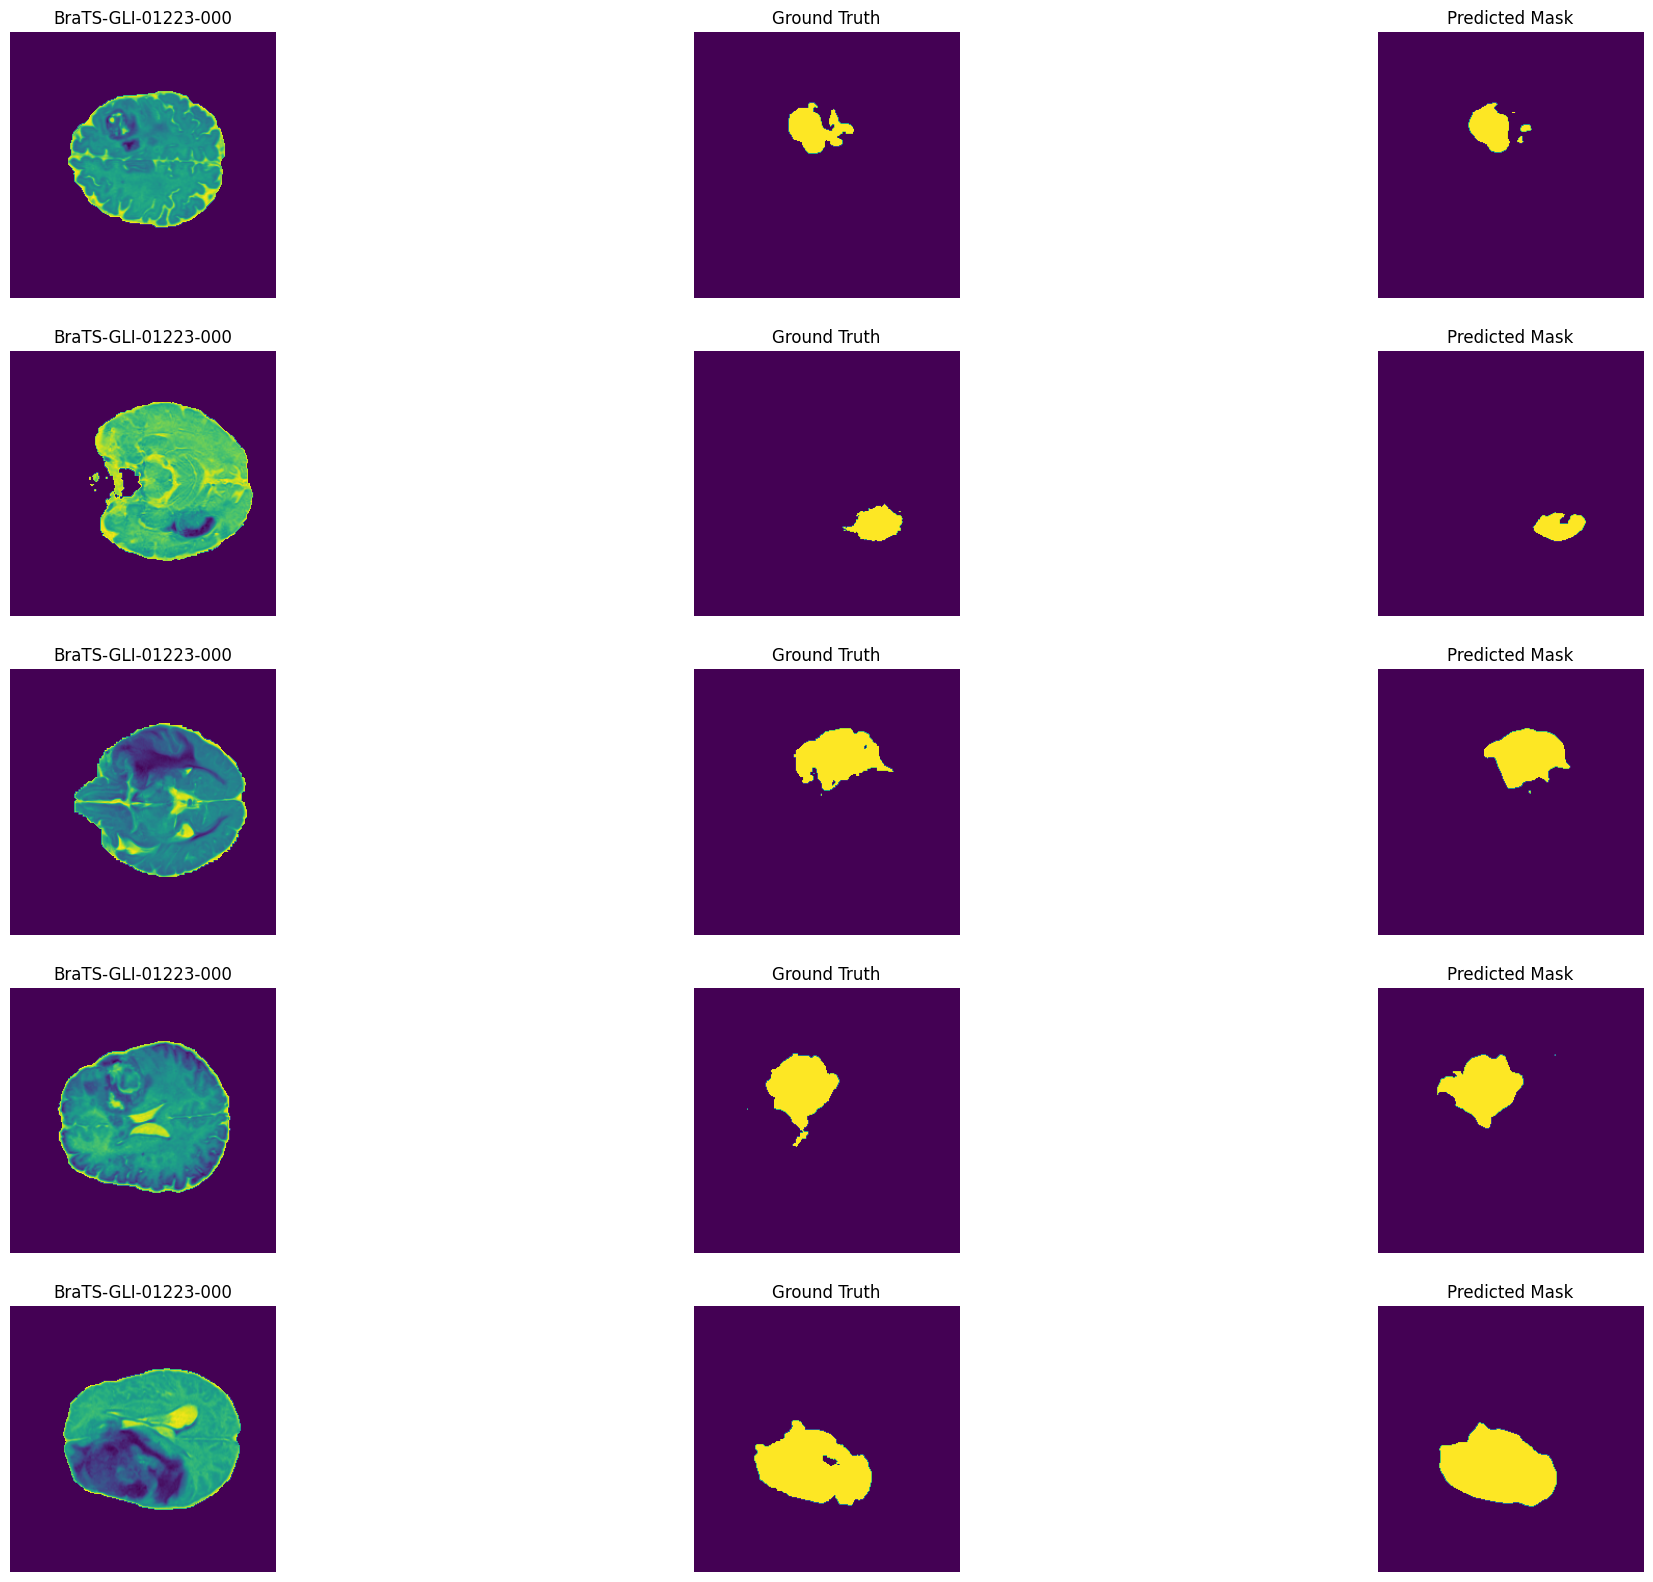

In [9]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import save_image

def inference(dl, model, device, n_ims=15):
    cols = n_ims // 3
    rows = n_ims // cols

    count = 1
    ims, gts, preds = [], [], []
    tr_iou_, tr_pa_, tr_mse_ = 0, 0, 0
    for idx, data in enumerate(dl):
        im, gt, patient_number = data

        # Move images and ground truths to the same device as the model
        im = im.to(device)
        gt = gt.to(device)

        # Get predicted mask
        with torch.no_grad():
            pred = torch.argmax(model(im), dim=1)
            #save_image(pred, patient_number[0]+'.png')

        # Ensure pred and gt are on the same device
        pred = pred.to(device)
        gt = gt.to(device)

        met = Metrics(pred, gt, loss_fn, n_cls=n_cls)
        print("patient number ",patient_number)
        print("IOU : ", met.PA())
        tr_pa_ += met.PA()
        print("MSE : ", met.mse_loss().item())
        print()
        tr_mse_ += met.mse_loss().item()
        ims.append(im.cpu())  # Move to CPU for plotting
        gts.append(gt.cpu())  # Move to CPU for plotting
        preds.append(pred.cpu())  # Move to CPU for plotting

    plt.figure(figsize=(25, 20))
    for idx, (im, gt, pred) in enumerate(zip(ims, gts, preds)):
        if idx == cols:
            break
        # First plot
        count = plot(cols, rows, count, im.squeeze(0), title=patient_number[0])

        # Second plot
        count = plot(cols, rows, count, im=gt.squeeze(0), gt=True, title="Ground Truth")

        # Third plot
        count = plot(cols, rows, count, im=pred, title="Predicted Mask")

    return  tr_pa_ / n_ims, tr_mse_ / n_ims

# Load the model and set the device
model = torch.load(f"saved_models/{save_prefix}_best_model.pt")
model = model.to(device)

# Run inference
tr_pa_, tr_mse_ = inference(test_dl, model=model, device=device)
print( "Global_PA: ",tr_pa_,", Global_MSE: ", tr_mse_)
